Air temperature is a relevant information for airlines and pilots as it affects air density which impacts maximum engine power or thrust. Thus high air temperatures limit maximum permissible takeoff weight of aircraft. That affects operating variables such as payload and total fuel loaded.

The purpose of this Jupyter Notebook is to **predict the Maximum Temperature at Madrid Barajas Airport through random forest model** using the Global Summary of the Month for Madrid Barajas from [National Oceanic and Atmospheric Administration (NOAA)]. 

The period of the employed dataset goes from 1997-01-01 to 2018-01-01. The table shown below describes the content of the dataset.

| Data Type | Description                                                         |
|-----------|---------------------------------------------------------------------|
| EMXP      | Extreme maximum precipitation for the period                        |
| EMXT      | Extreme maximum temperature for the period                          |
| PRCP      | Precipitation                                                       |
| DX90      | Number days with maximum temperature > 90 F (32.2C)                 |      
| DP10      | Number of days with >= 1.0 inch of precipitation                    |
| HDSD      | Heating Degree Days Season to Date                                  |
| HTDD      | Heating degree days                                                 |
| DX70      | Number days with maximum temperature > 70 F (21.1C)                 |
| DP01      | Number of days with >= 0.1 inch of precipitation                    |
| CDSD      | Cooling Degree Days Season to Date                                  |
| EMNT      | Extreme minimum temperature for the period                          |
| DT32      | Number days with minimum temperature less than or equal to 32.0 F   |
| DT00      | Number days with minimum temperature less than or equal to 0.0 F    |
| DX32      | Number days with maximum temperature < 32 F                         |
| CLDD      | Cooling Degree Days                                                 |
| TMAX      | Maximum temperature                                                 |
| TAVG      | Average Temperature                                                 |
| TMIN      | Minimum temperature                                                 |


[National Oceanic and Atmospheric Administration (NOAA)]: https://www.ncdc.noaa.gov/

In [1]:
import datetime  # for dealing with dates

import matplotlib.pyplot as plt  # plotting
import numpy as np  # linear algebra, arrays
import pandas as pd  # data structures
import seaborn as sns  # statistical data visualization

**Load Data**

Load data from file, display first 5 rows and check metric units

In [2]:
df = pd.read_csv("data/gsom_madrid_barajas_1997_2018.csv")
df.head(5)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,CDSD,CDSD_ATTRIBUTES,CLDD,CLDD_ATTRIBUTES,...,HTDD,HTDD_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
0,SPE00120278,"MADRID BARAJAS, SP",40.4667,-3.5556,609.0,1997-01,0.0,E,0.0,",E",...,363.9,",E",80.0,",,,E",6.6,",E",10.7,",,,E",2.5,",,,E"
1,SPE00120278,"MADRID BARAJAS, SP",40.4667,-3.5556,609.0,1997-02,0.0,E,0.0,",E",...,254.0,",E",1.9,",,,E",9.3,",E",16.1,",,,E",2.5,",,,E"
2,SPE00120278,"MADRID BARAJAS, SP",40.4667,-3.5556,609.0,1997-03,0.0,E,0.0,",E",...,171.7,",E",0.0,",,,E",12.8,",E",22.1,",,,E",3.4,",,,E"
3,SPE00120278,"MADRID BARAJAS, SP",40.4667,-3.5556,609.0,1997-04,2.4,E,2.4,",E",...,91.3,",E",35.9,",,,E",15.4,",E",22.4,",,,E",8.4,",,,E"
4,SPE00120278,"MADRID BARAJAS, SP",40.4667,-3.5556,609.0,1997-05,13.1,E,10.7,",E",...,66.0,",E",60.1,",,,E",16.6,",E",22.9,",,,E",10.1,",,,E"


**Identify and correct data**

Split DATE column with *YYYY-MM* format into YEAR and MONTH columns

In [3]:
df = df.assign(YEAR=df["DATE"].str.extract("^(....).*", expand=True))
df = df.assign(MONTH=df["DATE"].str.extract("(?<=[-])(..)", expand=True))

In [4]:
list(df.columns)

['STATION',
 'NAME',
 'LATITUDE',
 'LONGITUDE',
 'ELEVATION',
 'DATE',
 'CDSD',
 'CDSD_ATTRIBUTES',
 'CLDD',
 'CLDD_ATTRIBUTES',
 'DP01',
 'DP01_ATTRIBUTES',
 'DP10',
 'DP10_ATTRIBUTES',
 'DT00',
 'DT00_ATTRIBUTES',
 'DT32',
 'DT32_ATTRIBUTES',
 'DX32',
 'DX32_ATTRIBUTES',
 'DX70',
 'DX70_ATTRIBUTES',
 'DX90',
 'DX90_ATTRIBUTES',
 'EMNT',
 'EMNT_ATTRIBUTES',
 'EMXP',
 'EMXP_ATTRIBUTES',
 'EMXT',
 'EMXT_ATTRIBUTES',
 'HDSD',
 'HDSD_ATTRIBUTES',
 'HTDD',
 'HTDD_ATTRIBUTES',
 'PRCP',
 'PRCP_ATTRIBUTES',
 'TAVG',
 'TAVG_ATTRIBUTES',
 'TMAX',
 'TMAX_ATTRIBUTES',
 'TMIN',
 'TMIN_ATTRIBUTES',
 'YEAR',
 'MONTH']

Drop columns which are not going to be used in the model. DT00 and DX32 are filtered because their values are always zero

In [5]:
drop_columns = [
    "STATION",
    "NAME",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "DATE",
    "CDSD_ATTRIBUTES",
    "CLDD_ATTRIBUTES",
    "DP01_ATTRIBUTES",
    "DP10_ATTRIBUTES",
    "DT00_ATTRIBUTES",
    "DT00",
    "DT32_ATTRIBUTES",
    "DX32_ATTRIBUTES",
    "DX32",
    "DX70_ATTRIBUTES",
    "DX90_ATTRIBUTES",
    "EMNT_ATTRIBUTES",
    "EMXP_ATTRIBUTES",
    "EMXT_ATTRIBUTES",
    "HDSD_ATTRIBUTES",
    "HTDD_ATTRIBUTES",
    "PRCP_ATTRIBUTES",
    "TAVG_ATTRIBUTES",
    "TMAX_ATTRIBUTES",
    "TMIN_ATTRIBUTES",
]

df = df.drop(drop_columns, axis=1)

Check new filtered data

In [6]:
df.head(5)

,CDSD,CLDD,DP01,DP10,DT32,DX70,DX90,EMNT,EMXP,EMXT,HDSD,HTDD,PRCP,TAVG,TMAX,TMIN,YEAR,MONTH
0,0.0,0.0,14,9,6,0,0,-3.2,20.2,16.5,1101.1,363.9,80.0,6.6,10.7,2.5,1997,01
1,0.0,0.0,2,0,5,1,0,-1.8,1.5,21.8,1355.1,254.0,1.9,9.3,16.1,2.5,1997,02
2,0.0,0.0,0,0,1,24,0,0.0,0.0,26.0,1526.8,171.7,0.0,12.8,22.1,3.4,1997,03
3,2.4,2.4,5,3,0,20,0,3.0,18.0,27.4,1618.1,91.3,35.9,15.4,22.4,8.4,1997,04
4,13.1,10.7,11,6,0,21,0,1.9,13.9,29.8,1684.1,66.0,60.1,16.6,22.9,10.1,1997,05


In [7]:
df.shape

(253, 18)

In [8]:
df.describe()

,CDSD,CLDD,DP01,DP10,DT32,DX70,DX90,EMNT,EMXP,EMXT,HDSD,HTDD,PRCP,TAVG,TMAX,TMIN
count,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.00000,253.000000,253.000000,253.000000,253.000000
mean,327.252174,57.546640,5.913043,3.252964,4.102767,14.723320,5.027668,2.492095,12.201186,27.667589,940.325692,162.33083,31.130040,14.847431,21.449012,8.248221
std,319.139391,85.099926,4.367124,2.744266,6.619874,12.971371,8.433401,6.549744,9.681575,8.115993,791.912477,148.39501,28.790185,7.155853,8.232151,6.188658
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.500000,0.000000,14.200000,0.000000,0.00000,0.000000,2.300000,8.400000,-3.900000
25%,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,-2.900000,5.000000,20.000000,31.300000,8.10000,9.300000,8.300000,13.600000,2.800000
50%,263.000000,0.700000,5.000000,3.000000,0.000000,15.000000,0.000000,1.300000,10.800000,27.400000,966.000000,127.30000,22.600000,14.200000,20.800000,7.600000
75%,627.100000,103.700000,8.000000,4.000000,7.000000,29.000000,7.000000,8.300000,17.200000,35.300000,1710.400000,298.10000,44.300000,21.600000,29.400000,13.800000
max,849.400000,328.200000,18.000000,12.000000,29.000000,31.000000,30.000000,18.600000,58.900000,41.100000,2239.600000,497.00000,171.600000,28.900000,37.100000,20.800000


Boxplots for 16 features from CDSD to TMIN

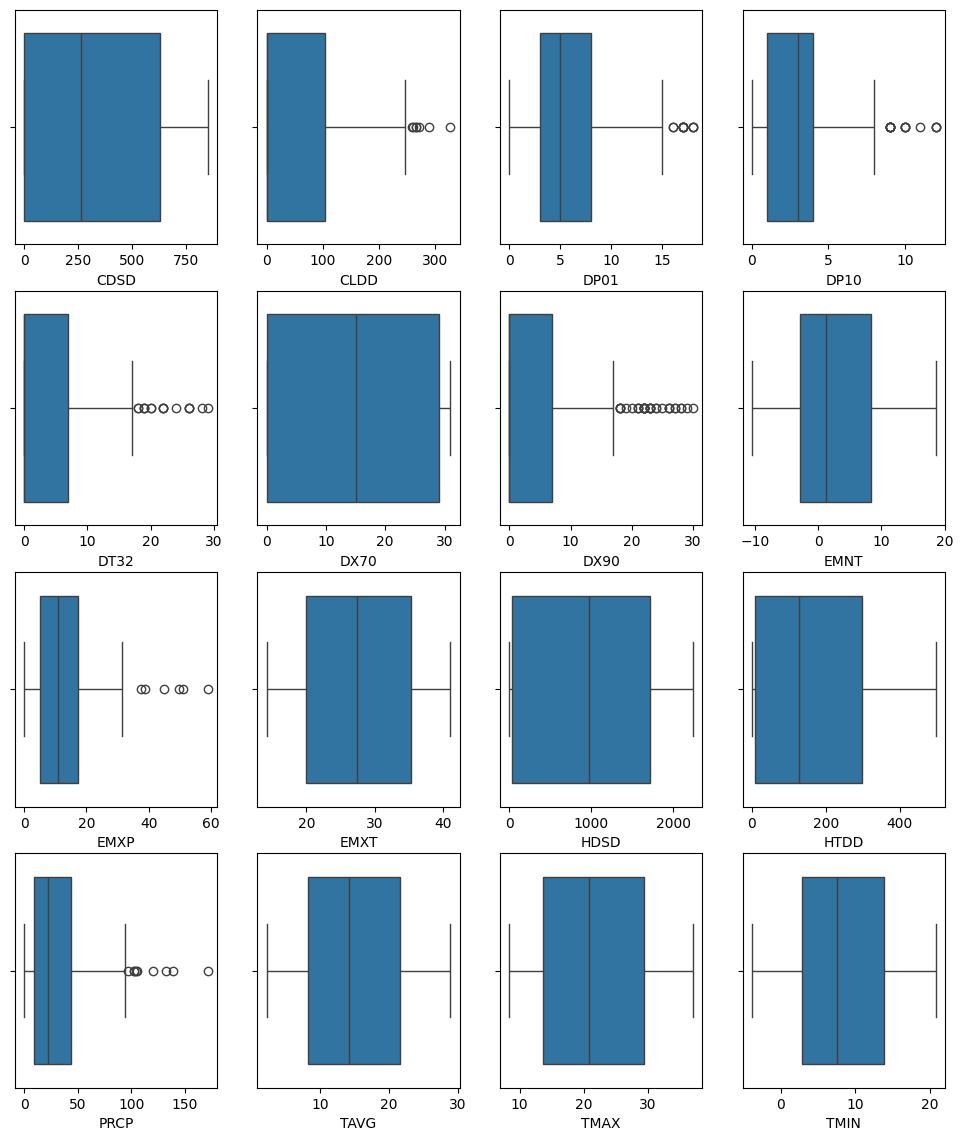

In [9]:
plt.figure(figsize=(12, 14))
x, y = 4, 4
for df_col in range(x * y):
    plt.subplot(y, x, df_col + 1)
    sns.boxplot(x=df.iloc[:, df_col], orient="horizontal")
plt.show()

Filter outliers

In [10]:
CLDDThreshold = np.percentile(df["CLDD"], 95)
df = df.loc[df["CLDD"] <= CLDDThreshold]  # df['CLDD'].quantile(.95)]

DP01Threshold = np.percentile(df["DP01"], 95)
df = df.loc[df["DP01"] <= DP01Threshold]

DP10Threshold = np.percentile(df["DP10"], 95)
df = df.loc[df["DP10"] <= DP10Threshold]

DT32Threshold = np.percentile(df["DT32"], 95)
df = df.loc[df["DT32"] <= DT32Threshold]

DX90Threshold = np.percentile(df["DX90"], 95)
df = df.loc[df["DX90"] <= DX90Threshold]

EMXPThreshold = np.percentile(df["EMXP"], 95)
df = df.loc[df["EMXP"] <= EMXPThreshold]

PRCPThreshold = np.percentile(df["PRCP"], 95)
df = df.loc[df["PRCP"] <= PRCPThreshold]

Boxplots after filter outliers

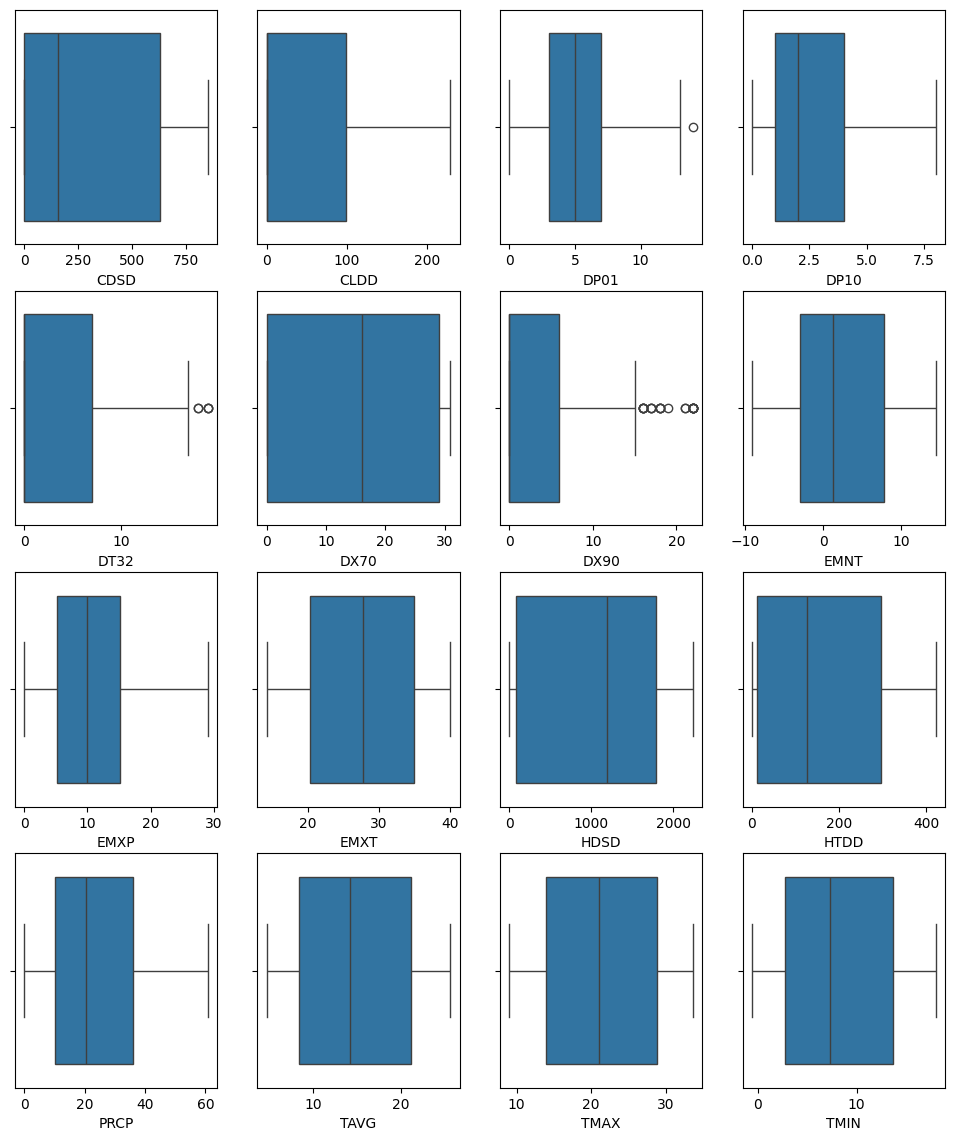

In [11]:
plt.figure(figsize=(12, 14))
x, y = 4, 4
for df_col in range(x * y):
    plt.subplot(y, x, df_col + 1)
    sns.boxplot(x=df.iloc[:, df_col], orient="horizontal")
plt.show()

Transform YEAR and MONTH columns into datetime objects used in plots

In [12]:
years = df["YEAR"]
months = df["MONTH"]

date = [year + "-" + month for year, month in zip(years, months, strict=True)]
date = [datetime.datetime.strptime(yearmonth, "%Y-%m") for yearmonth in date]

In [13]:
plt.style.available[:15]

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark']

Plotting TMAX, TAVG and TMIN for visual analysis

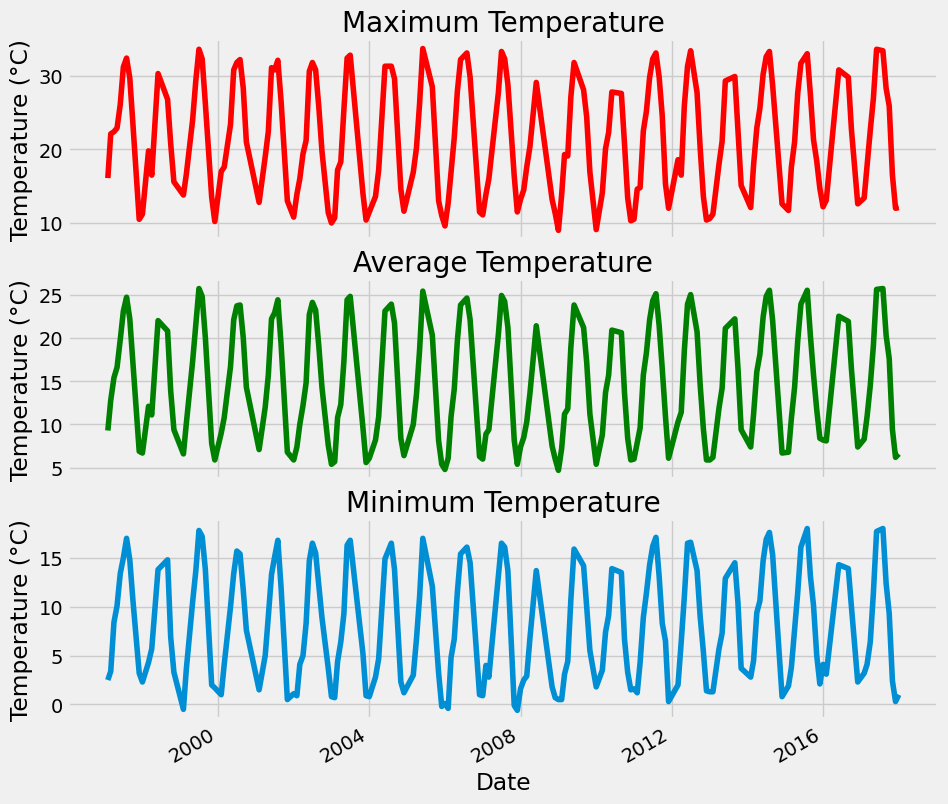

In [14]:
plt.style.use("fivethirtyeight")

# setting up plot layout
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
fig.autofmt_xdate()

ax1.plot(date, df["TMAX"], "r")
ax1.set_xlabel("")
ax1.set_ylabel("Temperature (°C)")
ax1.set_title("Maximum Temperature")

ax2.plot(date, df["TAVG"], "g")
ax2.set_xlabel("")
ax2.set_ylabel("Temperature (°C)")
ax2.set_title("Average Temperature")

ax3.plot(date, df["TMIN"])
ax3.set_xlabel("Date")
ax3.set_ylabel("Temperature (°C)")
ax3.set_title("Minimum Temperature");

**Prepare data for machine learning mode**

Building arrays for labels (TMAX column) and features (data columns excluding TMAX)

In [15]:
labels = np.array(df["TMAX"])
features = df.drop("TMAX", axis=1)
feature_columns = list(features.columns)  # column names of features
features = np.array(features)

Split data into training (75%) and testing (25%) datasets

In [16]:
from sklearn.model_selection import train_test_split

(train_features, test_features, train_labels, test_labels) = train_test_split(
    features, labels, test_size=0.25, random_state=8
)

In [17]:
print("Shapes:")
print(f"Train features: {train_features.shape} \nTrain labels: {train_labels.shape}")
print(f"Test features: {test_features.shape} \nTest labels: {test_labels.shape}")

Shapes:
Train features: (138, 17) 
Train labels: (138,)
Test features: (47, 17) 
Test labels: (47,)


Average baseline error using average temperatures (TAVG) as baseline prediction

In [18]:
baseline_prediction = test_features[:, feature_columns.index("TAVG")]
baseline_error = abs(baseline_prediction - test_labels)
print(f"average baseline error (°C): {round(np.mean(baseline_error), 2)}")

average baseline error (°C): 6.59


**Training random forest model**

In [19]:
from sklearn.ensemble import RandomForestRegressor

rfmodel = RandomForestRegressor(n_estimators=1000, random_state=4)
rfmodel.fit(train_features, train_labels);

**Predictions and performance metrics**

Mean absolute error (MAE), mean absolute percentage error (MAPE) and accuracy of model predictions with test data

In [20]:
predictions = rfmodel.predict(test_features)

errors = abs(predictions - test_labels)
print(f"mean absolute error (°C): {round(np.mean(errors), 2)}")

mape = 100 * (errors / test_labels)
print(f"mean absolute percentage error (%): {round(np.mean(mape), 2)}")

accuracy = 100 - np.mean(mape)
print(f"accuracy (%): {round(accuracy, 2)}")

mean absolute error (°C): 0.63
mean absolute percentage error (%): 3.65
accuracy (%): 96.35


Check depth of one tree from the forest 

In [21]:
tree = rfmodel.estimators_[4]
print(f"The depth of this tree is: {tree.tree_.max_depth}")

The depth of this tree is: 10


Show feature importances

In [22]:
importances = list(rfmodel.feature_importances_)

f_importances = [
    (feature, round(importance, 5))
    for feature, importance in zip(feature_columns, importances, strict=True)
]

f_importances = sorted(f_importances, key=lambda tup: tup[1], reverse=True)

[print(f"Feature: {tup[0]} ({tup[1]})") for tup in f_importances];

Feature: TAVG (0.45787)
Feature: HTDD (0.2298)
Feature: DX70 (0.14255)
Feature: TMIN (0.05508)
Feature: EMXT (0.05284)
Feature: CLDD (0.04855)
Feature: DX90 (0.00604)
Feature: EMNT (0.00372)
Feature: DP01 (0.00069)
Feature: DT32 (0.00059)
Feature: YEAR (0.00044)
Feature: HDSD (0.0004)
Feature: EMXP (0.00038)
Feature: CDSD (0.00036)
Feature: PRCP (0.00035)
Feature: DP10 (0.00022)
Feature: MONTH (0.00013)


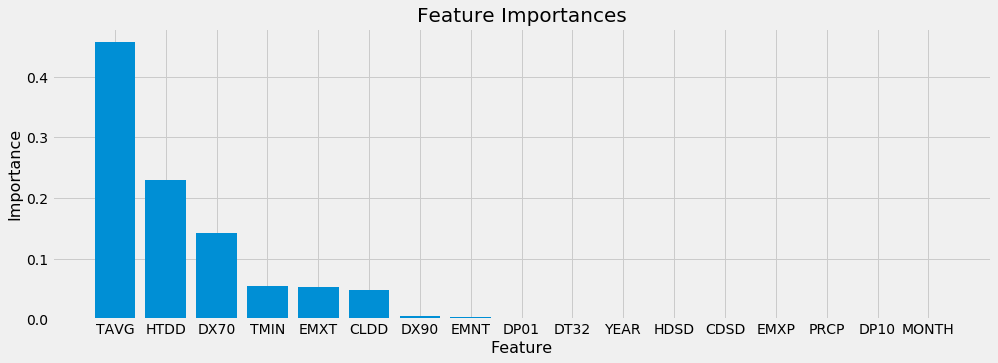

In [23]:
plt.figure(figsize=(15, 5))
plt.bar(*zip(*f_importances, strict=True))
plt.ylabel("Importance", fontsize=16)
plt.xlabel("Feature", fontsize=16)
plt.title("Feature Importances", fontsize=20);

**Simplifying the model**

Create new random forest model with only the top 3 important features and maximum tree depth of 3

In [24]:
rfmodel_top3 = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=4)

top3_features = [
    feature_columns.index("TAVG"),
    feature_columns.index("HTDD"),
    feature_columns.index("DX70"),
]

train_top3_f = train_features[:, top3_features]
test_top3_f = test_features[:, top3_features]

rfmodel_top3.fit(train_top3_f, train_labels);

Compare MAE and accuracy of simplified random forest model with previous one

In [25]:
predictions_top3 = rfmodel_top3.predict(test_top3_f)

errors_top3 = abs(predictions_top3 - test_labels)
print(f"mean absolute error with top 3 features (°C): {round(np.mean(errors_top3), 2)}")
print(f"mean absolute error with all features (°C): {round(np.mean(errors), 2)}")

mape_top3 = 100 * (errors_top3 / test_labels)
accuracy_top3 = 100 - np.mean(mape_top3)
print(f"accuracy with top 3 features (%): {round(accuracy_top3, 2)}")
print(f"accuracy with all features (%): {round(accuracy, 2)}")

mean absolute error with top 3 features (°C): 0.83
mean absolute error with all features (°C): 0.63
accuracy with top 3 features (%): 95.19
accuracy with all features (%): 96.35


Check depth of one tree from the forest

In [26]:
tree_top3 = rfmodel_top3.estimators_[44]
print(f"The depth of this tree is: {tree_top3.tree_.max_depth}")

The depth of this tree is: 3


Graph of decision tree as png image

In [28]:
import pydot  # graph description language
from sklearn.tree import export_graphviz  # graph visualization

export_graphviz(
    tree_top3,
    out_file="tree_top3.dot",
    feature_names=["TAVG", "HTDD", "DX70"],
    rounded=True,
    precision=1,
)

(graph,) = pydot.graph_from_dot_file("tree_top3.dot")

graph.write_png("images/tree_top3.png");

![title](images/tree_top3.png)